In [1]:
# pip install xgboost
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv('../transactions_train/transactions_train.csv')

In [5]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [6]:
df.isnull().values.any()

False

In [7]:
df.count()

step              6351193
type              6351193
amount            6351193
nameOrig          6351193
oldbalanceOrig    6351193
newbalanceOrig    6351193
nameDest          6351193
oldbalanceDest    6351193
newbalanceDest    6351193
isFraud           6351193
dtype: int64

In [8]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))  #['TRANSFER', 'CASH_OUT']

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 3849

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 3868


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 3849

 The number of fraudulent CASH_OUTs = 3868


In [9]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False

print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False

print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False

#Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.


Are there any merchants among originator accounts for CASH_IN transactions? False

Are there any merchants among destination accounts for CASH_OUT transactions? False

Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


In [10]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [11]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \genuine CASH_OUTs: \n\n{}'
      .format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT']
                                                                .nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of \genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldbalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
1030443             0.0  C1714931087             0.0             0.0        1  
6039814             0.0   C423543548             0.0             0.0        1  


In [12]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [13]:
X.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [14]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

In [15]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldbalanceDest\' = \
\'newbalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4952701827134897

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006186832925410947


In [16]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = - 1

In [17]:
X.loc[(X.oldbalanceDest == -1) & (X.newbalanceDest == -1)]

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.00,0.0,-1.0,-1.0
251,1,0,2806.00,2806.00,0.0,-1.0,-1.0
680,1,0,20128.00,20128.00,0.0,-1.0,-1.0
969,1,0,1277212.77,1277212.77,0.0,-1.0,-1.0
1115,1,0,35063.63,35063.63,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...
6351149,699,0,257643.59,257643.59,0.0,-1.0,-1.0
6351182,699,0,215013.30,215013.30,0.0,-1.0,-1.0
6351185,699,0,62372.43,62372.43,0.0,-1.0,-1.0
6351188,699,0,162326.52,162326.52,0.0,-1.0,-1.0


In [18]:
X.loc[(X.oldbalanceOrig == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), ['oldbalanceOrig', 'newbalanceOrig']] = np.nan

In [19]:
X['errorbalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrig
X['errorbalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [20]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [21]:
trainX.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,errorbalanceOrig,errorbalanceDest
2509820,205,1,38073.06,174303.12,136230.05,12671731.70,12709804.77,-0.01,-1.000000e-02
1743720,161,1,189497.23,20639.00,0.00,157237.98,346735.20,168858.23,1.000000e-02
2509477,205,1,337626.06,NaN,NaN,1524443.34,1862069.40,NaN,2.328306e-10
480153,19,1,43826.99,NaN,NaN,98772.54,155535.69,NaN,-1.293616e+04
4640354,330,1,179833.53,5068.00,0.00,3009146.37,3188979.90,174765.53,0.000000e+00


In [55]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)

probabilities = clf.fit(trainX, trainY).predict_proba(testX)
ypred = clf.fit(trainX, trainY).predict(testX)

print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

C:\Users\paladugu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [57]:
 ypred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [70]:
#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

cm = metrics.confusion_matrix(testY, ypred)
print(cm)
print('\n\n')

#Classification metrics
print(classification_report(testY,ypred, target_names=['Not Fraud','Fraud']))

[[551504     16]
 [     7   1511]]



              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    551520
       Fraud       0.99      1.00      0.99      1518

    accuracy                           1.00    553038
   macro avg       0.99      1.00      1.00    553038
weighted avg       1.00      1.00      1.00    553038



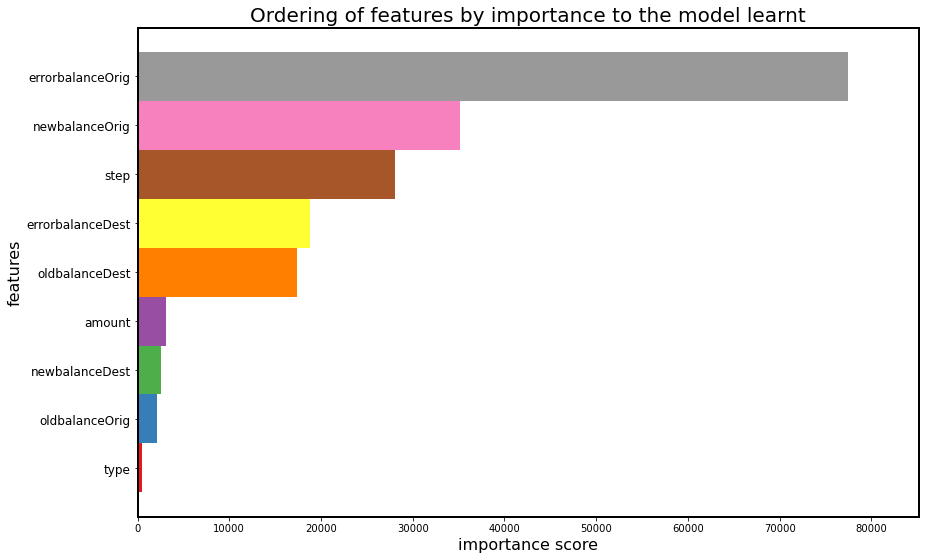

In [39]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, show_values = False, importance_type = 'cover', ax = ax);

for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [75]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=357.32396008811713,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)